In [5]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.datasets import load_iris, load_wine

# Sklearn imports
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

# DiCE imports
import dice_ml
from dice_ml.utils import helpers  # helper functions

import lib.baseline as baseline
import lib.util as util
from lib.baycon import baycon_explainer

from lib.eval.eval_metrics import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
X, true_y = load_wine(return_X_y=True)
km = KMeans(n_clusters=3)
y = km.fit_predict(X)

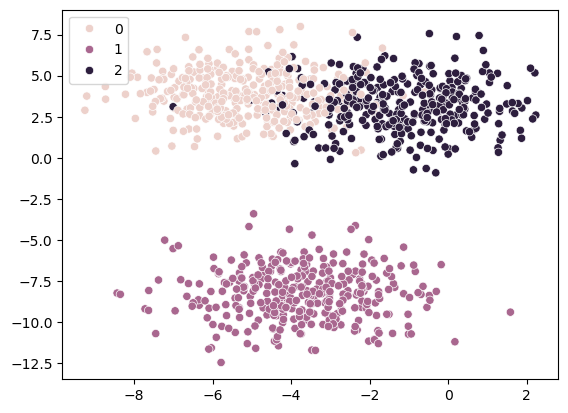

In [7]:
X, y = make_blobs(centers=3, cluster_std=1.5, n_features=2, n_samples=1000)
# eX = PCA(n_components=2).fit_transform(X)
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y)
plt.show()

In [8]:
idx = 0
print(f"init point cluster: {y[idx]}")
target_cluster = 2

init point cluster: 0


In [9]:
numerical = ["x1", "x2"]


df = pd.DataFrame(X, columns=numerical)
df["y"] = y
X = df.drop('y', axis=1)
d = dice_ml.Data(dataframe=df, outcome_name='y', continuous_features=numerical)

In [10]:
# FOR HANDLING CATEGORICAL DATA:
# categorical = df.drop('y', axis=1).columns.difference(numerical)
# print(categorical)

# categorical_transformer = Pipeline(steps=[
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# transformations = ColumnTransformer(
#     transformers=[
#         ('cat', categorical_transformer, categorical)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
# clf = Pipeline(steps=[('preprocessor', transformations),
#                       ('classifier', RandomForestClassifier())])

clf = RandomForestClassifier()
model = clf.fit(X, y)

In [11]:
# Using sklearn backend
m = dice_ml.Model(model=model, backend="sklearn")
# Using method=random for generating CFs
exp = dice_ml.Dice(d, m, method="random")

In [12]:
e1 = exp.generate_counterfactuals(X[idx:idx+1], total_CFs=20, desired_class=target_cluster)
e1.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [02:14<00:00, 134.23s/it]

Query instance (original outcome : 0)


,x1,x2,y
0,-5.093327,4.903605,0



Diverse Counterfactual set (new outcome: 2)


,x1,x2,y
0,-0.56692342664,-,2.0
1,1.70165081615,-,2.0
2,-2.88088951159,-0.407844317,2.0
3,1.40198926937,-,2.0
4,-2.89744129477,2.591472366,2.0
5,-0.3639869367,-,2.0
6,1.8355610563,4.659144564000828,2.0
7,0.26634449404,-,2.0
8,0.06505716504,-,2.0
9,-1.92108492706,-1.695289116,2.0


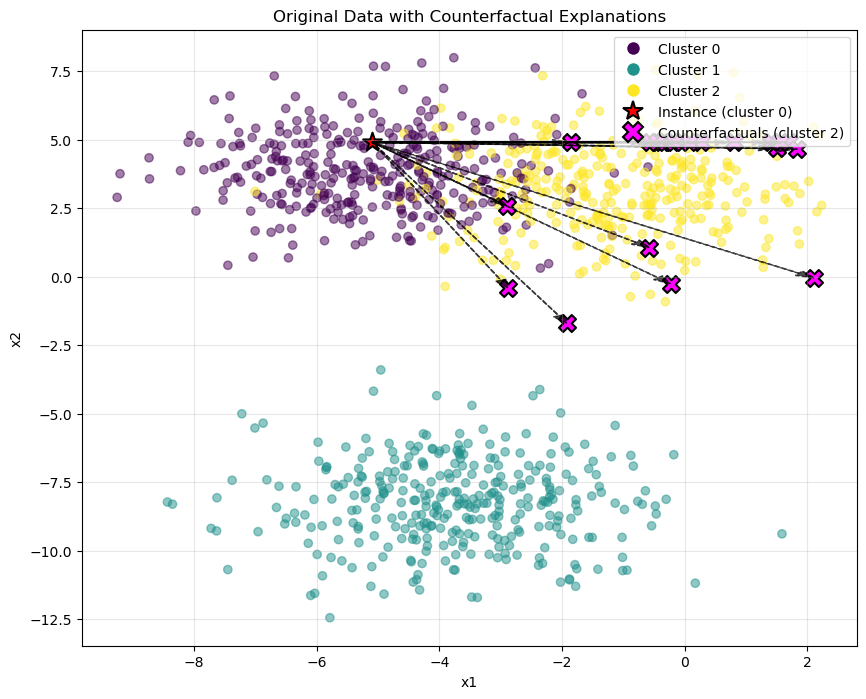

In [13]:
plt.figure(figsize=(10, 8))

# Plot all data points
scatter = plt.scatter(X['x1'], X['x2'], c=y, cmap='viridis', alpha=0.5)

# Get the instance we're explaining
instance = X.iloc[idx]

# Highlight the instance being explained
plt.scatter(instance['x1'], instance['x2'], color='red', s=200, marker='*', 
            edgecolor='black', linewidth=1.5, label=f'Instance (cluster {y[idx]})')

# Extract counterfactuals
cf_instances = e1.cf_examples_list[0].final_cfs_df
plt.scatter(cf_instances['x1'], cf_instances['x2'], color='magenta', s=150, marker='X', 
            edgecolor='black', linewidth=1.5, label=f'Counterfactuals (cluster {target_cluster})')

# Draw arrows from the instance to each counterfactual
for i in range(len(cf_instances)):
    plt.arrow(instance['x1'], instance['x2'], 
              cf_instances['x1'].iloc[i] - instance['x1'], 
              cf_instances['x2'].iloc[i] - instance['x2'], 
              color='black', width=0.01, head_width=0.2, 
              length_includes_head=True, alpha=0.7, linestyle='--')

# Create legend handles for each cluster
unique_clusters = sorted(np.unique(y))
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', 
                             markerfacecolor=scatter.cmap(scatter.norm(cluster_id)), 
                             markersize=10, label=f'Cluster {cluster_id}') 
                  for cluster_id in unique_clusters]

# Add other elements to the legend handles
legend_handles.append(plt.Line2D([0], [0], marker='*', color='w', 
                               markerfacecolor='red', markersize=15, 
                               markeredgecolor='black', markeredgewidth=1.5,
                               label=f'Instance (cluster {y[idx]})'))

legend_handles.append(plt.Line2D([0], [0], marker='X', color='w', 
                               markerfacecolor='magenta', markersize=15, 
                               markeredgecolor='black', markeredgewidth=1.5,
                               label=f'Counterfactuals (cluster {target_cluster})'))

plt.title('Original Data with Counterfactual Explanations')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend(handles=legend_handles, loc='upper right')
plt.grid(True, alpha=0.3)
plt.show()

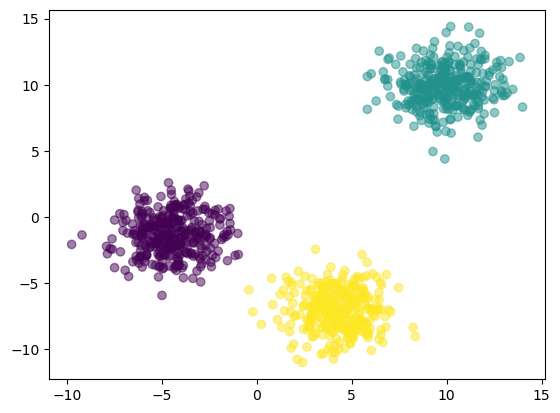

In [14]:
from lib.dice import dice_explainer

X,y = make_blobs(centers=3, cluster_std=1.5, n_features=2, n_samples=1000)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', alpha=0.5)
plt.show()

In [15]:
cf = dice_explainer(X, model, 0, 2)

TypeError: dice_explainer() takes from 0 to 1 positional arguments but 4 were given